 # Xgboostの概要
 XgboostはGBDT(Gradient Boosting Decision Tree)の手法の1つである.

# デフォルト設定での交差検証
パラメータの意味と調整によるスコアの違いを確認する前に, デフォルト設定でどの程度スコアがでるか確認する. データセットはTitanic dataset, 検証方法は交差検証を用いる.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("TitanicData/train.csv")
test = pd.read_csv("TitanicData/test.csv")

PassengerID = test["PassengerId"]
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# 前処理

import re
# merge train and test
full_data = [train,test]

# 特徴量の追加
# 名前の長さを保持する"Name_length"を生成
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Cabinが欠損値かどうかを0,1で保持する"Has_Cabin"を生成 
# Dataframe.apply() : 各要素ごとに処理
# lambda 引数 : 式
# 各要素の型がfloat(NaN)のとき0,それ以外のとき1を"Has_Cabin"に格納
train["Has_Cabin"] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test["Has_Cabin"] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# 特徴量エンジニアリング
for dataset in full_data: # trainとtestのそれぞれについて
    # 搭乗していた家族の人数の特徴量を生成
    # 搭乗していた家族の人数 = 兄弟,配偶者の人数 + 親,子供の人数 + 1(自分)
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1

for dataset in full_data:
    # 1人で搭乗したいたかどうかの特徴量を生成
    dataset["IsAlone"] = 0
    # "Familysize"が1のレコードの"IsAlone"を1に上書き
    dataset.loc[dataset["FamilySize"]==1,"IsAlone"] = 1

for dataset in full_data:
    # "Embarked"の欠損値を"S"で埋める
    dataset["Embarked"] = dataset["Embarked"].fillna("S")
    # "Fare"の欠損値を訓練セットの中央値で埋める
    dataset["Fare"] = dataset["Fare"].fillna(train["Fare"].median())
# Fareを訓練セットの四分位数で離散化した"CategoricalFare"特徴量を生成
train["CategoricalFare"] = pd.qcut(train["Fare"],4)

for dataset in full_data:
    age_avg = dataset["Age"].mean() # Ageの平均
    age_std = dataset["Age"].std() # Ageの標準偏差
    age_null_count = dataset["Age"].isnull().sum() # AgeがNanのレコード数をカウント
    age_null_random_list = np.random.randint(age_avg-age_std,age_avg+age_std,size=age_null_count) # age_avgを中心として2*age_stdの範囲で乱数を生成
    dataset["Age"][np.isnan(dataset["Age"])] = age_null_random_list # AgeがNanのレコードに生成した乱数を代入
    dataset["Age"] = dataset["Age"].astype(int) # Ageをint型に変換
train["CategoricalAge"] = pd.cut(train["Age"],5) # Ageを分位数5で離散化した"CategoricalAge"特徴量を生成

def get_title(name):
    """名前から敬称を抽出する関数
    Args:
    name(str) : 敬称を抽出する文字列
    
    Returns:
    敬称 : 敬称が文字列に含まれるとき
    "" : 敬称が文字列に含まれないとき
    """
    # 正規表現
    # () : 文字を一つのグループにまとめる
    # A-Za-z : 1桁の全角英字(大文字)と1桁の全角英字(大文字)
    # + 直前の文字が1回以上繰り返すときにマッチする
    # \. .(ドット)
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    # "Name"の各要素をget_title関数に渡して,結果を"Title"に格納する.
    dataset["Title"] = dataset["Name"].apply(get_title)

for dataset in full_data:
    # 稀な敬称を"Rare"に置換
    dataset["Title"] = dataset["Title"].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 
                                                 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    # 表記を統一
    dataset["Title"] = dataset["Title"].replace("Mlle","Miss")
    dataset["Title"] = dataset["Title"].replace("Ms","Miss")
    dataset["Title"] = dataset["Title"].replace("Mme","Mrs")
    
for dataset in full_data:
    # "femaleを0,maleを1にエンコーディング"
    dataset["Sex"] = dataset["Sex"].map({"female":0,"male":1}).astype(int)
    
    # Embarkedをエンコーディング
    dataset["Embarked"] = dataset["Embarked"].map({"S":0,"C":1,"Q":2}).astype(int)
    
    # 敬称をエンコーディング
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Fareを四分位で離散化
    dataset.loc[dataset["Fare"]<=7.91,"Fare"] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Ageを分位数5で離散化
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

# 特徴選択
drop_features = ["PassengerId","Name","Ticket","Cabin","SibSp"]
train = train.drop(drop_features,axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test = test.drop(drop_features,axis=1)
train.head()

<ipython-input-3-ced32c63f5cb>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["Age"][np.isnan(dataset["Age"])] = age_null_random_list # AgeがNanのレコードに生成した乱数を代入


,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


In [4]:
X_train = train.drop(columns=["Survived"])
y_train = train["Survived"]

In [7]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train) # xgboostようにデータを変換
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss"
}

model = xgb.train(xgb_params,dtrain)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

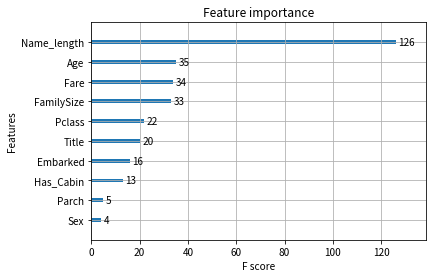

In [9]:
# feature importance
xgb.plot_importance(model)

<Figure size 1080x1080 with 0 Axes>

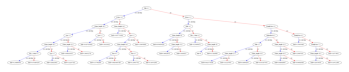

In [13]:
# tree 
plt.figure(figsize=(15,15))
xgb.plot_tree(model, num_trees=2)
plt.show()

## 交差検証

In [14]:
dtrain = xgb.DMatrix(X_train, label=y_train) # xgboostようにデータを変換
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss"
}

model = xgb.cv(xgb_params,dtrain,nfold=5,verbose_eval=True)

[0]	train-logloss:0.55304+0.00310	test-logloss:0.57190+0.00718
[1]	train-logloss:0.47487+0.00310	test-logloss:0.50734+0.01447
[2]	train-logloss:0.42277+0.00441	test-logloss:0.46922+0.01923
[3]	train-logloss:0.38773+0.00532	test-logloss:0.44557+0.02235
[4]	train-logloss:0.36159+0.00637	test-logloss:0.43359+0.02273
[5]	train-logloss:0.34179+0.00735	test-logloss:0.42476+0.02235
[6]	train-logloss:0.32716+0.00741	test-logloss:0.42105+0.02463
[7]	train-logloss:0.31543+0.00812	test-logloss:0.41990+0.02476
[8]	train-logloss:0.30470+0.00788	test-logloss:0.41962+0.02768
[9]	train-logloss:0.29612+0.00835	test-logloss:0.42059+0.02886


# パラメータ

- eta : etaは学習率で過学習を防止するために調整します.
- gamma : gammaは決定木の葉の追加による損失減少の下限を意味します. 決定木が複雑になると過学習を起こしやすくなるため, 葉の数に対するペナルティを与える.
- max_depth : 決定木の深さの最大値を意味する. 値が大きいほどモデルが複雑になるため過学習する可能性が高くなる.
- min_child_weight : 決定木の葉の重みの下限を表します. この下限が大きいほど単調な木になり, 過学習を抑制する.
- objective : 損失関数の設定
- eval_metric : 評価指標
- nrounds : ブースティングを行う回数